<a href="https://colab.research.google.com/github/Bobinjraj/Realtime-Offensive-language-detection/blob/main/Real_time_Offensive_language_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
keras = tf.keras
layers = keras.layers
Tokenizer = keras.preprocessing.text.Tokenizer

In [ ]:
df = pd.read_csv('/content/labeled_data.csv', header=0)

In [ ]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


We don't need first 4 columns

In [ ]:
# drop first 5 columns. we don't need them
df = df.drop(df.columns[:5], axis=1)

df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
feature_columns = ['hate_speech','offensive_language','ok']

## Preprocessing

Let's devide them into train,eval and test datasets.
there's about 25k records.

but before that we need to see few things.

In [ ]:
dfc = df.copy()

df_hate_speech = dfc[dfc['class']==0]
df_offensive = dfc[dfc['class']==1]
df_ok = dfc[dfc['class']==2]

print("There are",len(df_hate_speech), "hate speech records.","and ",len(df_offensive),"offensive records","and",len(df_ok),"are ok")

There are 1202 hate speech records. and  15367 offensive records and 3402 are ok


In [ ]:
df_ok.head(20)

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
40,2,""" momma said no pussy cats inside my doghouse """
63,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
67,2,"""@Allyhaaaaa: Lemmie eat a Oreo &amp; do these..."
70,2,"""@ArizonasFinest6: Why the eggplant emoji doe?..."
75,2,"""@BabyAnimalPics: baby monkey bathtime http://..."
115,2,"""@DomWorldPeace: Baseball season for the win. ..."
118,2,"""@DunderbaIl: I'm an early bird and I'm a nigh..."
119,2,"""@EdgarPixar: Overdosing on heavy drugs doesn'..."


There are 1430 hate speech records. and  19190 offensive records and 4163 are ok. Let's get the ratio

In [ ]:
print("ratio to hate speech:offensive records:ok are ",len(df_hate_speech)/1430,":",len(df_offensive)/1430,":",len(df_ok)/1430)

ratio to hate speech:offensive records:ok are  0.8405594405594405 : 10.746153846153845 : 2.379020979020979


ratio to hate speech:offensive records:ok are  1.0 : 13.4 : 2.9

comparing to other records there are too many records are in offensive category. If we don't trim this ratio it will cause our predictive model to have a tendency to predict ok or hate speech tweets as offensive.

I will remove 1/2 of them that will trim it down to 9595.
total records will be trimmed down to 15185.

In [ ]:
df_offensive = df_offensive[5000:14595]
len(df_offensive)

9595

In [ ]:
df_offensive.head()

,class,tweet
6725,1,@morganwelborn you're a bitch
6726,1,@moyizzy naw negro
6728,1,@mrfoolycooly @DM___3 faggot alert
6729,1,@mrfoolycooly bitch ass scaring me! Lol you do...
6731,1,@mrfoolycooly im still where that giant muk sh...


In [ ]:
# merge dataframes
dfc = pd.concat([df_hate_speech,df_offensive,df_ok], axis=0)

# shuffle the dataframe
dfc = dfc.sample(frac=1, random_state=42).reset_index(drop=True)
dfc.head()

,class,tweet
0,1,"If you're a whiney bitch, have a ZIMA and shut..."
1,1,"RT @BitchNiggaAlexx: ""Go talk to your other ho..."
2,1,RT @_MCBaybeh1218: Keep ur bitch on a leash .
3,1,RT @YBEToot: @UFUCKIN_RIGHT what hoes tho ? Lol.
4,1,RT @TattedUp_Tre: &#8220;@Blaxxxican: Early bi...


In [ ]:
dfc.shape

(14199, 2)

We got 15188 records.

In [ ]:
df = dfc.copy()
num_of_rows = len(df.index)
p80 = round(num_of_rows * 0.8)
p99 = round(num_of_rows * 0.99)

train_features = df[0:p80]
eval_features = df[p80:p99]
test_features = df[p99:]

train_labels = train_features.pop('class')
eval_labels = eval_features.pop('class')
test_labels = test_features.pop('class')
print(train_features.shape)
print(eval_features.shape)
print(test_features.shape)

(11359, 1)
(2698, 1)
(142, 1)


(12150, 1)

(2886, 1)

(152, 1)

In [ ]:
train_labels.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

## Encoding words

max length, vocab size

In [ ]:
padding_type = 'pre'
max_len = 60
trun_type='post'
oov_token = '<oov>'

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(train_features['tweet'])

vocab_size = len(tokenizer.word_index) + 1 # add 1 more, otherwise there will be a out ouf bound index error
vocab_size
# tokenizer.word_index

22588

vocab_size = 23731

In [ ]:
# convert panda dataframe of labels to numpy array
train_labels = np.array(train_labels)
eval_labels = np.array(eval_labels)
test_labels = np.array(test_labels)

# convert each label to array of categorical values
train_labels = keras.utils.to_categorical(train_labels,3)
eval_labels = keras.utils.to_categorical(eval_labels,3)
test_labels = keras.utils.to_categorical(test_labels,3)

In [ ]:
train_features_seq = tokenizer.texts_to_sequences(train_features['tweet'])
eval_features_seq = tokenizer.texts_to_sequences(eval_features['tweet'])

padding the arrays

In [ ]:
train_features_seq = keras.utils.pad_sequences(train_features_seq,max_len,padding=padding_type)
eval_features_seq = keras.utils.pad_sequences(eval_features_seq,max_len,padding=padding_type)
len(train_features_seq[0])

60

In [ ]:
train_features_seq = np.array(train_features_seq)
eval_features_seq = np.array(eval_features_seq)
eval_features_seq.shape

(2698, 60)

## Building the model

In [ ]:
num_of_classes = len(feature_columns)

# neural network 01
model1 = keras.Sequential([
    keras.layers.Embedding(vocab_size,32,input_length=max_len),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(24,activation='relu'),
    keras.layers.Dense(num_of_classes,activation='softmax')
])

# neural network 02
model2 = keras.Sequential([
    keras.layers.Embedding(vocab_size,32,input_length=max_len),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(num_of_classes,activation='softmax')
])

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 32)            722816    
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 723683 (2.76 MB)
Trainable params: 723683 (2.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## First model

In [ ]:
epochs = 200

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model1.fit(train_features_seq,train_labels,epochs=epochs,verbose=2,callbacks=[early_stopping])

Epoch 1/200
355/355 - 5s - loss: 0.8251 - accuracy: 0.6706 - 5s/epoch - 14ms/step
Epoch 2/200
355/355 - 4s - loss: 0.5383 - accuracy: 0.8058 - 4s/epoch - 10ms/step
Epoch 3/200
355/355 - 3s - loss: 0.3682 - accuracy: 0.8761 - 3s/epoch - 9ms/step
Epoch 4/200
355/355 - 3s - loss: 0.2967 - accuracy: 0.8916 - 3s/epoch - 9ms/step
Epoch 5/200
355/355 - 4s - loss: 0.2373 - accuracy: 0.9181 - 4s/epoch - 12ms/step
Epoch 6/200
355/355 - 3s - loss: 0.1810 - accuracy: 0.9452 - 3s/epoch - 9ms/step
Epoch 7/200
355/355 - 3s - loss: 0.1323 - accuracy: 0.9621 - 3s/epoch - 9ms/step
Epoch 8/200
355/355 - 3s - loss: 0.1005 - accuracy: 0.9701 - 3s/epoch - 9ms/step
Epoch 9/200
355/355 - 4s - loss: 0.0759 - accuracy: 0.9776 - 4s/epoch - 12ms/step
Epoch 10/200
355/355 - 3s - loss: 0.0579 - accuracy: 0.9831 - 3s/epoch - 9ms/step
Epoch 11/200
355/355 - 3s - loss: 0.0461 - accuracy: 0.9879 - 3s/epoch - 9ms/step
Epoch 12/200
355/355 - 4s - loss: 0.0359 - accuracy: 0.9911 - 4s/epoch - 10ms/step
Epoch 13/200
355/355

It only ran 54 epochs because our early stopping functioning stopped the fitting. early stopping function is there to stop overfitting.

In [ ]:
history.history['accuracy'][-1]

0.9994717836380005

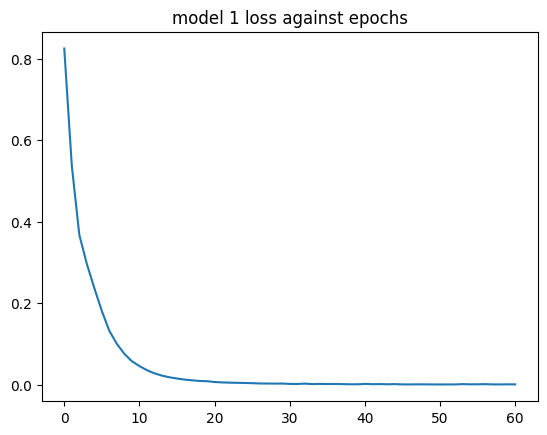

In [ ]:
plt.plot(history.history['loss'])
plt.xLabel='epoch'
plt.yLabel='loss'
plt.title('model 1 loss against epochs')
plt.show()

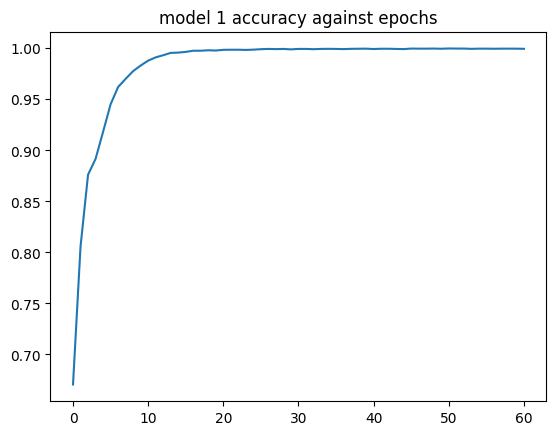

In [ ]:
plt.plot(history.history['accuracy'])
plt.xLabel='epoch'
plt.yLabel='accuracy'
plt.title('model 1 accuracy against epochs')
plt.show()

After about 15-20 epochs model1 is fully trained.

In [ ]:
loss1,acc1 = model1.evaluate(eval_features_seq,eval_labels)

85/85 [==============================] - 0s 2ms/step - loss: 1.4796 - accuracy: 0.8176


## model1's accuracy: 0.8109 with eval data.

## Second model

In [ ]:
epochs = 20

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model2_history = model2.fit(train_features_seq,train_labels,epochs=epochs,verbose=2,callbacks=[early_stopping])

Epoch 1/20
355/355 - 22s - loss: 0.5795 - accuracy: 0.7830 - 22s/epoch - 62ms/step
Epoch 2/20
355/355 - 18s - loss: 0.3230 - accuracy: 0.8863 - 18s/epoch - 50ms/step
Epoch 3/20
355/355 - 17s - loss: 0.2087 - accuracy: 0.9334 - 17s/epoch - 47ms/step
Epoch 4/20
355/355 - 17s - loss: 0.1250 - accuracy: 0.9619 - 17s/epoch - 47ms/step
Epoch 5/20
355/355 - 18s - loss: 0.0729 - accuracy: 0.9777 - 18s/epoch - 51ms/step
Epoch 6/20
355/355 - 17s - loss: 0.0432 - accuracy: 0.9886 - 17s/epoch - 47ms/step
Epoch 7/20
355/355 - 17s - loss: 0.0309 - accuracy: 0.9915 - 17s/epoch - 48ms/step
Epoch 8/20
355/355 - 18s - loss: 0.0227 - accuracy: 0.9932 - 18s/epoch - 51ms/step
Epoch 9/20
355/355 - 17s - loss: 0.0158 - accuracy: 0.9962 - 17s/epoch - 47ms/step
Epoch 10/20
355/355 - 17s - loss: 0.0130 - accuracy: 0.9965 - 17s/epoch - 47ms/step
Epoch 11/20
355/355 - 17s - loss: 0.0111 - accuracy: 0.9967 - 17s/epoch - 49ms/step
Epoch 12/20
355/355 - 19s - loss: 0.0067 - accuracy: 0.9982 - 19s/epoch - 54ms/step
E

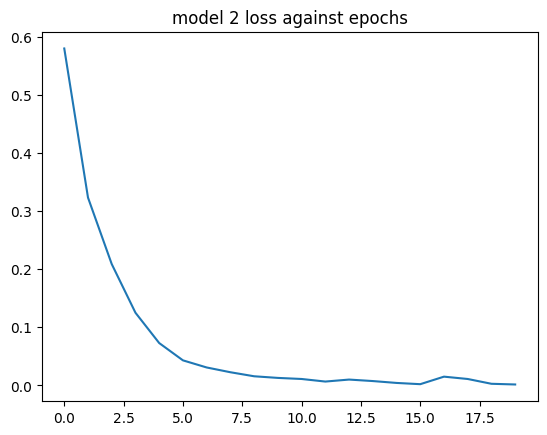

In [ ]:
plt.plot(model2_history.history['loss'])
plt.xLabel='epoch'
plt.yLabel='loss'
plt.title('model 2 loss against epochs')
plt.show()

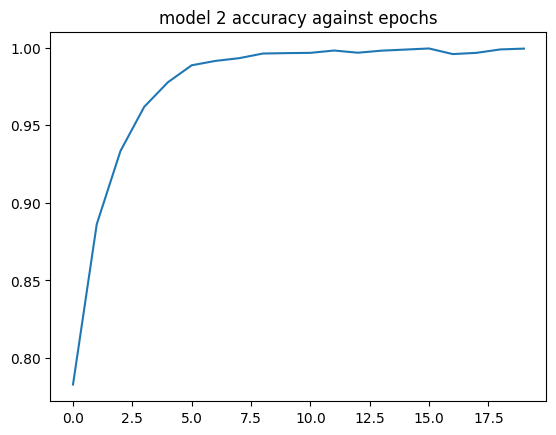

In [ ]:
plt.plot(model2_history.history['accuracy'])
plt.xLabel='epoch'
plt.yLabel='accuracy'
plt.title('model 2 accuracy against epochs')
plt.show()

In [ ]:
loss2,acc2 = model2.evaluate(eval_features_seq,eval_labels)

85/85 [==============================] - 2s 11ms/step - loss: 0.8740 - accuracy: 0.8532


## Model2's accuracy: 0.8532 with eval data

We'll use model2 since it is more accurate.

In [ ]:
# reset the index of test_features and labels
test_features = test_features.reset_index(drop=True)
test_features.head()

,tweet
0,"One of my favorite songs. ""There's a man on th..."
1,"RT @KINGSHA_MUGGA: My bitch better lie to me, ..."
2,Nah bitch you just ugly
3,Fuck her pussy &#127814;&#128047; Fuck her mou...
4,My main bitch is a ghost


In [ ]:
model2.save('hate_comment_detection_with_nlp_v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = keras.models.load_model('hate_comment_detection_with_nlp_v2.h5')

In [ ]:
def manual_test(index):
  encoded = tokenizer.texts_to_sequences([test_features.loc[index]['tweet']])
  encoded = keras.utils.pad_sequences(encoded,60,padding='pre',truncating='post')
  preds = model.predict(encoded)
  pred = preds[-1]
  classification = feature_columns[np.argmax(pred)]
  confidence = np.max(pred) *100
  print("tweet is",test_features.loc[index]['tweet'],"\nprediction/classification is",classification,".confidence",confidence,"%")

index = input("pick a index below 152: ")
manual_test(int(index))

pick a index below 152: 30
1/1 [==============================] - 0s 25ms/step
tweet is I'm tryna face fuck kesha, you bitches bringin beef I'll get the lettuce n ketchup 
prediction/classification is offensive_language .confidence 99.99957084655762 %


Now let's predict our own comment.

first we have to encode that using tokenizer.

In [ ]:
import json

with open('hate_comment_detection_with_nlp_word_index_v2.json', 'w') as file:
    json.dump(tokenizer.word_index, file)

In [ ]:
import json
# Open the file containing the word index
with open('hate_comment_detection_with_nlp_word_index_v2.json', 'r') as file:
    data = json.load(file)

# Convert the JSON data to a dictionary
word_index = dict(data)

change the my_tweet and see the prediction

In [ ]:
feature_columns = ['hate_speech','offensive_language','ok']

my_tweet = "LOVE YOU"

oov_token = '<oov>'

tokenizer = Tokenizer(oov_token=oov_token)
tokenizer.word_index = word_index
encoded = tokenizer.texts_to_sequences([my_tweet])
encoded = keras.utils.pad_sequences(encoded,60,padding='pre',truncating='post')

pred = model.predict(encoded)

classification = feature_columns[np.argmax(pred[-1])]
confidence = np.max(pred[-1]) *100
# if pred doesn't have at least 90% confidence I will consider as ok.
if confidence < 90:
  classification = 'ok'
print("\nprediction/classification is",classification)

1/1 [==============================] - 0s 26ms/step

prediction/classification is ok
